## Importing Libraries

In [10]:
!pip install category_encoders

In [79]:
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np
from scipy.stats import zscore
from sklearn.ensemble import IsolationForest
import category_encoders as ce
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from cuml.neighbors import KNeighborsClassifier       # GPU Accelerated
import cudf  # GPU DataFrame
from cuml.metrics import accuracy_score
from sklearn.metrics import classification_report, confusion_matrix
import time
import joblib
import shutil
from cuml.svm import SVC
from cuml.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier, plot_tree

In [62]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


## Exploratory Data Analysis


### Loading Dataset

In [13]:
data=pd.read_csv("/content/drive/MyDrive/MoMTSim_20240722202413_1000_dataset.csv")
data.head()

,step,transactionType,amount,initiator,oldBalInitiator,newBalInitiator,recipient,oldBalRecipient,newBalRecipient,isFraud
0,0,PAYMENT,579.16,4018807983755588,29.32,29.32,30-0000345,0.00,0.00,0
1,0,TRANSFER,39.03,4610593854752035,39.03,0.00,4944921135715488,55.94,94.98,1
2,0,TRANSFER,21.78,4840578447365454,21.78,0.00,4305579785620656,58.09,79.88,1
3,0,PAYMENT,570.22,4958066799829630,5.29,5.29,00-0000388,0.00,0.00,0
4,0,PAYMENT,574.80,4149196095918843,82.63,82.63,80-0005320,0.00,0.00,0


- ***Step Means TimeStep For Example 0 would mean the Transaction Ocurred at the Beginning.***
- ***TransactionType tell is nature of transaction For Example Deposit,Payment etc.***
- ***Amount tell us the monetary value of Transaction.***
- ***TransactionType tell is nature of transaction For Example Deposit,Payment etc.***
- ***initiator means the sender account id.***
- ***oldBalInitiator means the senders balance before the transaction.***
- ***newBalInitiator means the senders balance after the transaction.***
- ***recipient means the reciver account id.***
- ***oldBalRecipient means the recivers balance before the transaction.***
- ***newBalRecipient means the recivers after before the transaction.***
- ***isFraud tell whether the transaction is Fraud or Not.***






### Basic Information and Structure

In [14]:
# shape of data
data.shape

(4225958, 10)

In [15]:
# columns/Features
data.columns

Index(['step', 'transactionType', 'amount', 'initiator', 'oldBalInitiator',
       'newBalInitiator', 'recipient', 'oldBalRecipient', 'newBalRecipient',
       'isFraud'],
      dtype='object')

In [16]:
# info about data types
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225958 entries, 0 to 4225957
Data columns (total 10 columns):
 #   Column           Dtype  
---  ------           -----  
 0   step             int64  
 1   transactionType  object 
 2   amount           float64
 3   initiator        int64  
 4   oldBalInitiator  float64
 5   newBalInitiator  float64
 6   recipient        object 
 7   oldBalRecipient  float64
 8   newBalRecipient  float64
 9   isFraud          int64  
dtypes: float64(5), int64(3), object(2)
memory usage: 322.4+ MB


In [17]:
# changing data types to appropriate to ensure consitency
data['transactionType'] = data['transactionType'].astype('category')
data['initiator'] = data['initiator'].astype('object')
data['isFraud'] = data['isFraud'].astype(bool)
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4225958 entries, 0 to 4225957
Data columns (total 10 columns):
 #   Column           Dtype   
---  ------           -----   
 0   step             int64   
 1   transactionType  category
 2   amount           float64 
 3   initiator        object  
 4   oldBalInitiator  float64 
 5   newBalInitiator  float64 
 6   recipient        object  
 7   oldBalRecipient  float64 
 8   newBalRecipient  float64 
 9   isFraud          bool    
dtypes: bool(1), category(1), float64(5), int64(1), object(2)
memory usage: 266.0+ MB


- ***transactionType is Categorical***
- ***initiator is Categorical***
- ***recipient is Categorical***
- -----------------------------
- ***step is Numerical***
- ***amount is Numerical***
- ***oldBalInitiator is Numerical***
- ***newBalInitiator is Numerical***
- ***oldBalRecipient is Numerical***
- ***newBalRecipient is Numerical***
- ***isFraud is Numerical***


In [18]:
# descriptive stats
data.describe()

,step,amount,oldBalInitiator,newBalInitiator,oldBalRecipient,newBalRecipient
count,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06,4.225958e+06
mean,9.811771e+01,5.302139e+04,2.246055e+07,2.246527e+07,1.685005e+06,1.703967e+06
std,5.573710e+01,2.708194e+06,6.418504e+07,6.421561e+07,6.795783e+06,6.802160e+06
min,0.000000e+00,0.000000e+00,-1.999926e+05,-1.999926e+05,-7.477966e+04,0.000000e+00
25%,5.000000e+01,9.444000e+01,4.681000e+01,0.000000e+00,3.345156e+04,4.251237e+04
50%,9.900000e+01,5.966900e+02,3.655435e+03,0.000000e+00,2.007614e+05,2.042479e+05
75%,1.470000e+02,1.708469e+04,2.344082e+05,8.150306e+04,2.002134e+06,2.041814e+06
max,1.920000e+02,7.654805e+08,6.409231e+08,6.409231e+08,3.810134e+08,3.813883e+08


### Identifying and Handling Missing Values

In [19]:
# missing values
data.isnull().sum()

,0
step,0
transactionType,0
amount,0
initiator,0
oldBalInitiator,0
newBalInitiator,0
recipient,0
oldBalRecipient,0
newBalRecipient,0
isFraud,0


***There are No Missing Values in the Dataset.***


### Analyzing Distribution of Features and Target Class

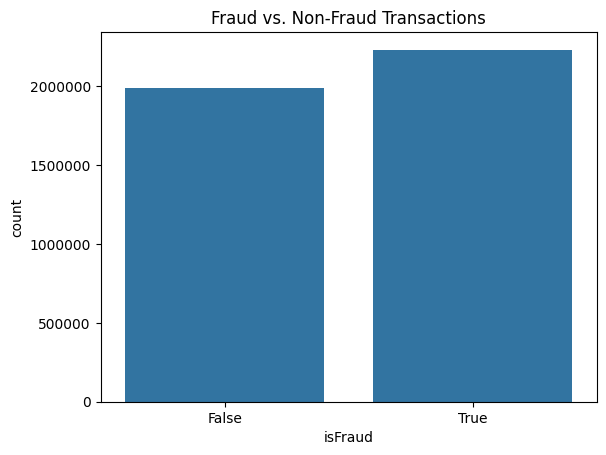

In [20]:
# Target Class Distribution - Fraud vs Non Fraud
sns.countplot(x='isFraud', data=data)
plt.title("Fraud vs. Non-Fraud Transactions")
plt.ticklabel_format(style='plain', axis='y')
plt.show()

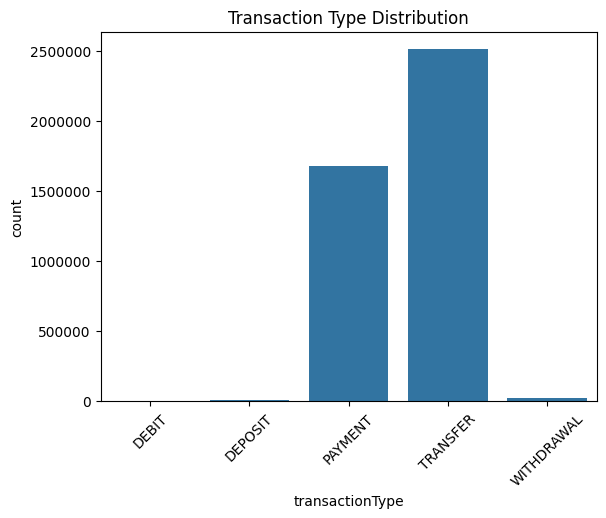

In [21]:
# Transaction Type Distribution
sns.countplot(x='transactionType', data=data)
plt.title("Transaction Type Distribution")
plt.xticks(rotation=45)
plt.ticklabel_format(style='plain', axis='y')
plt.show()

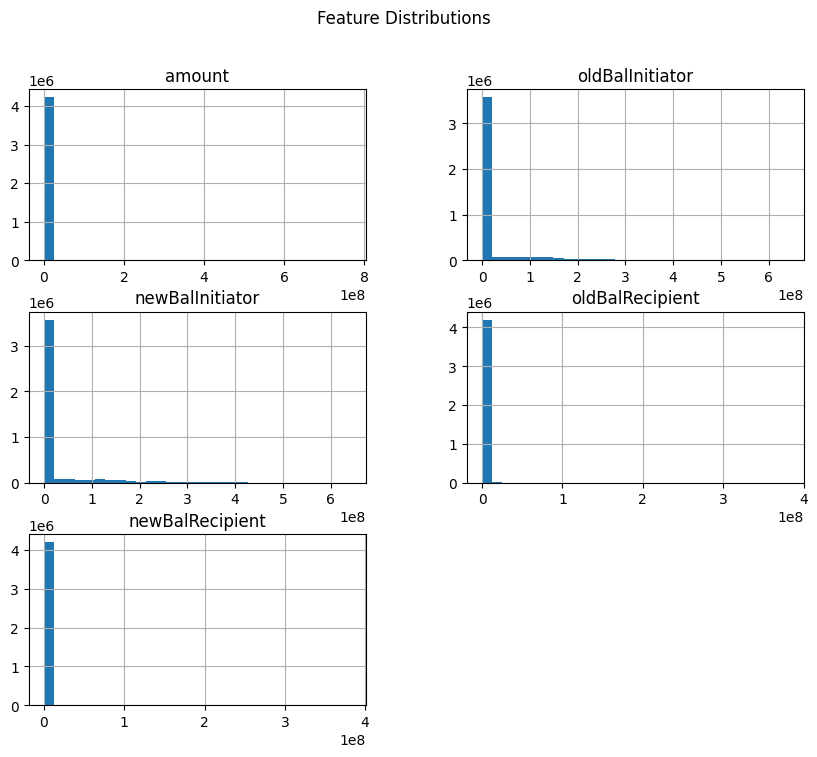

In [22]:
# Distribution of Remaining Numerical Features
num_cols = ['amount', 'oldBalInitiator', 'newBalInitiator', 'oldBalRecipient', 'newBalRecipient']
data[num_cols].hist(figsize=(10, 8), bins=30)
plt.suptitle("Feature Distributions")
plt.show()


***We can see that values/plot are heavily Skewed Right meaning most values are small, and a few values are extremely large so we can apply log to even out values***

/usr/local/lib/python3.11/dist-packages/pandas/core/arraylike.py:399: RuntimeWarning: invalid value encountered in log1p
  result = getattr(ufunc, method)(*inputs, **kwargs)


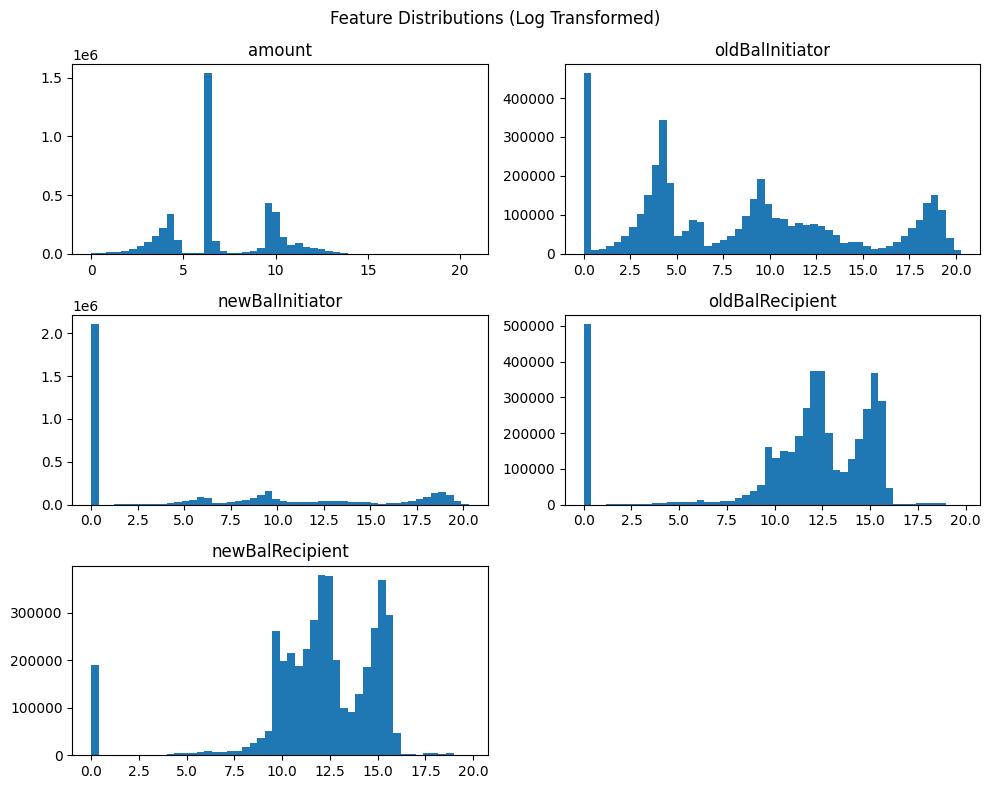

In [23]:
num_cols = ['amount', 'oldBalInitiator', 'newBalInitiator', 'oldBalRecipient', 'newBalRecipient']

plt.figure(figsize=(10, 8))
for i, feature in enumerate(num_cols, 1):
    plt.subplot(3, 2, i)
    plt.hist(np.log1p(data[feature]), bins=50)  # Log transformation to even out values
    plt.title(feature)
plt.suptitle("Feature Distributions (Log Transformed)")
plt.tight_layout()
plt.show()

### Identifying potential outliers and Handling Them

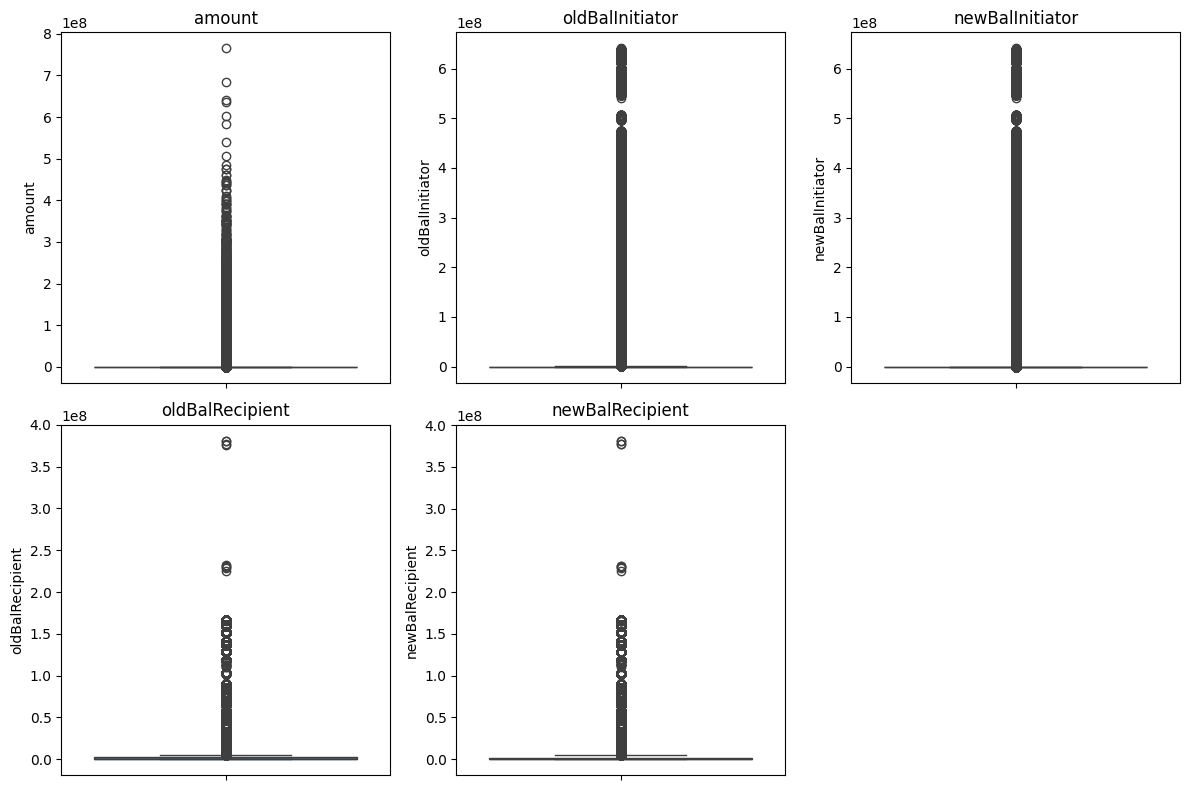

In [24]:
# Boxplot Visualization
num_features = ['amount', 'oldBalInitiator', 'newBalInitiator', 'oldBalRecipient', 'newBalRecipient']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

In [25]:
# Quantative Outlier Detection Using IQR
def detectoutliersiqr(df, feature):
    Q1 = np.percentile(df[feature], 25)
    Q3 = np.percentile(df[feature], 75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[feature] < lower_bound) | (df[feature] > upper_bound)]
    return outliers

for feature in num_features:
    outliers = detectoutliersiqr(data, feature)
    print(f"{feature}: {len(outliers)} outliers detected")

amount: 370472 outliers detected
oldBalInitiator: 898754 outliers detected
newBalInitiator: 1004925 outliers detected
oldBalRecipient: 357957 outliers detected
newBalRecipient: 348787 outliers detected


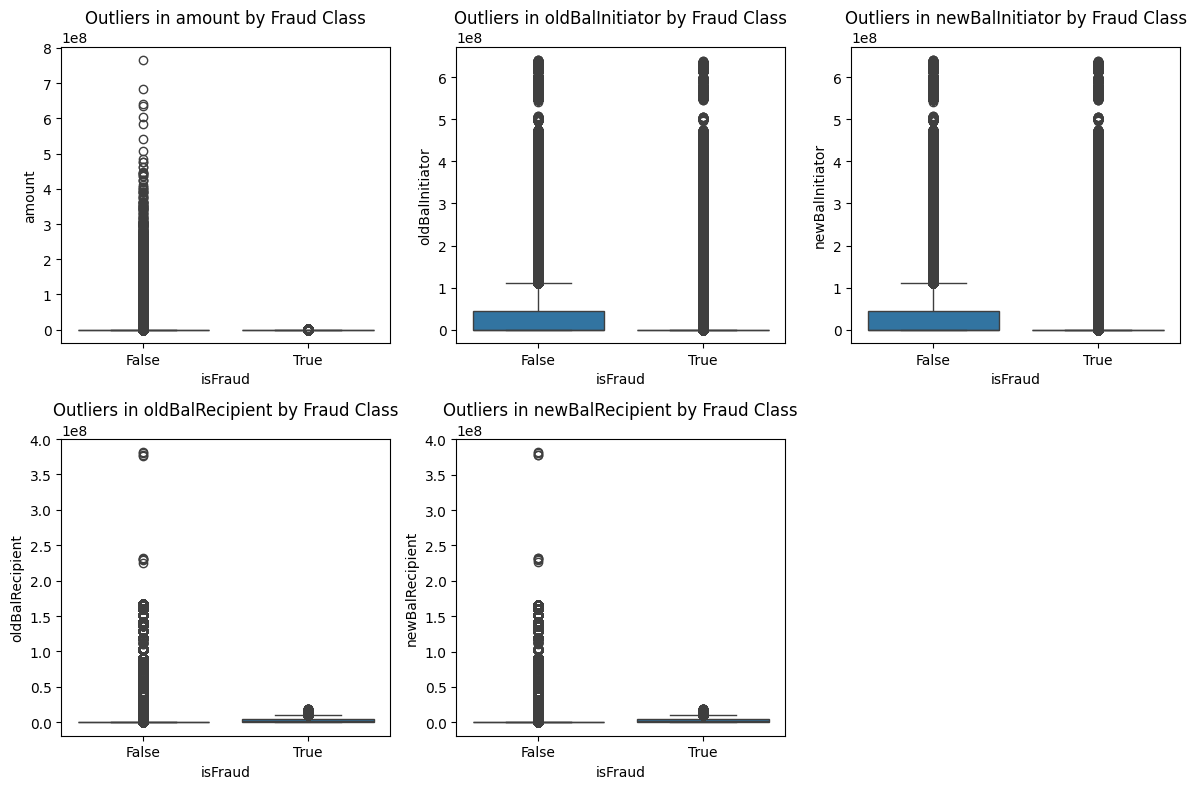

In [26]:
# Features wrt Target Class - isFraud
plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(x=data["isFraud"], y=data[feature])
    plt.title(f"Outliers in {feature} by Fraud Class")
plt.tight_layout()
plt.show()

In [27]:
# Outlier Detection Using zscore
zscores = data[num_features].apply(zscore)

# with thresh abs_zscore > 3
outliers_zscore = (zscores.abs() > 3).sum()
print("Outliers detected using Z-score method:")
print(outliers_zscore)

Outliers detected using Z-score method:
amount                876
oldBalInitiator    134167
newBalInitiator    134150
oldBalRecipient     22758
newBalRecipient     22786
dtype: int64


In [28]:
iso_forest = IsolationForest(contamination=0.01, random_state=42)

for feature in num_features:
    data[f"{feature}_Outlier"] = (iso_forest.fit_predict(data[[feature]]) == -1).astype(int)

for feature in num_features:
    print(f"Outliers detected in {feature}: {data[f'{feature}_Outlier'].sum()}")

Outliers detected in amount: 40179
Outliers detected in oldBalInitiator: 41695
Outliers detected in newBalInitiator: 42015
Outliers detected in oldBalRecipient: 42101
Outliers detected in newBalRecipient: 41669


In [29]:
# # Now outliers cant be directly removed as we dont know whether these outliers are genruine noise or can be indicators in case of fraud so best approach
# # is we remove extremely high values and then use log transform and winsorization-needs testing


# # 99 percentile
# threshold = data['amount'].quantile(0.99)
# df_outliers = data[data['amount'] > threshold]
# fraud_rate_outliers = df_outliers['isFraud'].mean() * 100
# print(f"Fraud rate in outliers above {threshold:.2f}: {fraud_rate_outliers:.2f}%")
# overall_fraud_rate = data['isFraud'].mean() * 100
# print(f"Overall fraud rate: {overall_fraud_rate:.2f}%")

# #checking some unrealistic values
# df_unrealistic = data[data['amount'] > 1e8]
# print("Number of transactions above $100M:", len(df_unrealistic))
# print("Fraud rate among these transactions:", df_unrealistic['isFraud'].mean() * 100, "%")



In [30]:
# removing outliers using Isolation Forest as currently it seems the best approach here as we are balanced in case of removal of outliers

outlier_flags = [f"{feature}_Outlier" for feature in num_features]
data["Combined_Outlier"] = data[outlier_flags].max(axis=1)
data_cleaned = data[data["Combined_Outlier"] == 0].copy()

print("Data shape before removal:", data.shape)
print("Data shape after removal:", data_cleaned.shape)


Data shape before removal: (4225958, 16)
Data shape after removal: (4102723, 16)


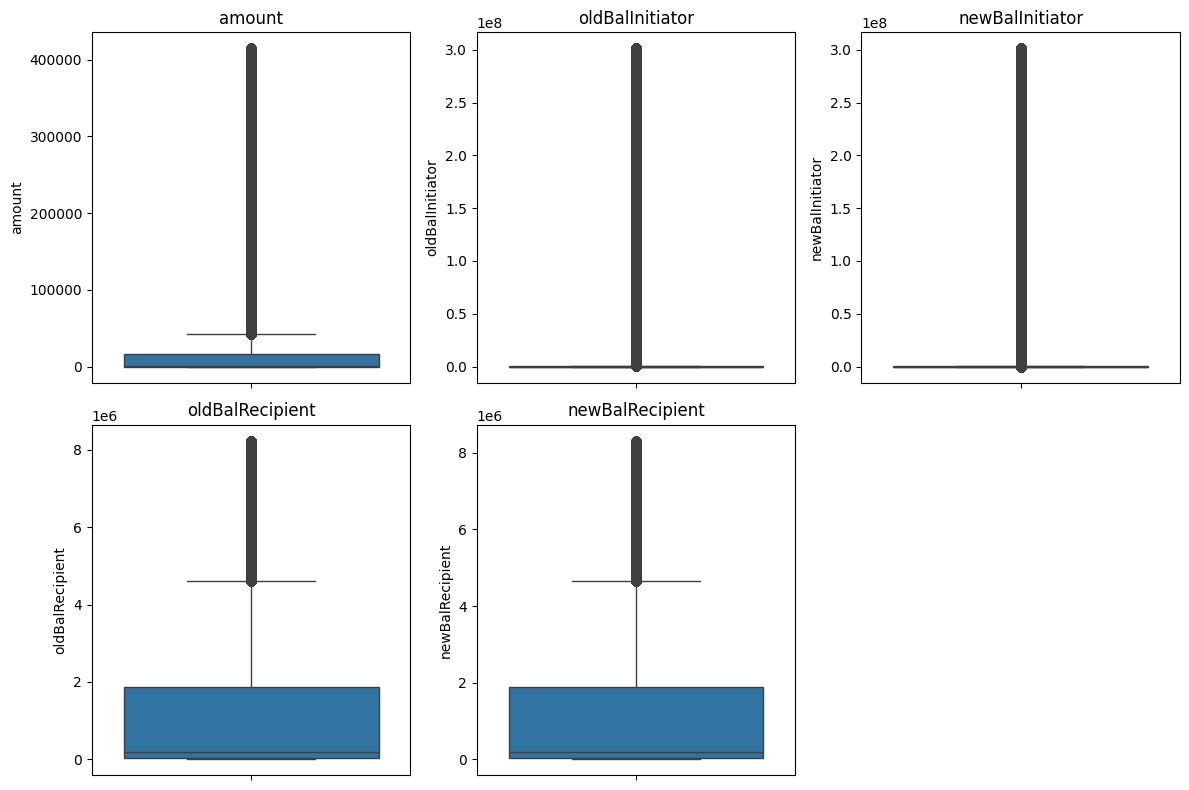

In [31]:
# Boxplot Visualization After Removing Outliers
num_features = ['amount', 'oldBalInitiator', 'newBalInitiator', 'oldBalRecipient', 'newBalRecipient']

plt.figure(figsize=(12, 8))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.boxplot(y=data_cleaned[feature])
    plt.title(feature)
plt.tight_layout()
plt.show()

### Visualization of Relationship b/w Features and Target Class


<ipython-input-32-cfe523ff1dd2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_cleaned[data_cleaned['isFraud'] == 0][feature], shade=True, label="Non-Fraud", color="blue")
<ipython-input-32-cfe523ff1dd2>:7: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_cleaned[data_cleaned['isFraud'] == 1][feature], shade=True, label="Fraud", color="red")
<ipython-input-32-cfe523ff1dd2>:6: FutureWarning: 

`shade` is now deprecated in favor of `fill`; setting `fill=True`.
This will become an error in seaborn v0.14.0; please update your code.

  sns.kdeplot(data=data_cleaned[data_cleaned['isFraud'] == 0][feature], shade=True, label="Non-Fraud", color="blue")
<ipython-input-32-cfe523ff1dd2>:7: FutureWarning: 

`shade` is now deprecated in 

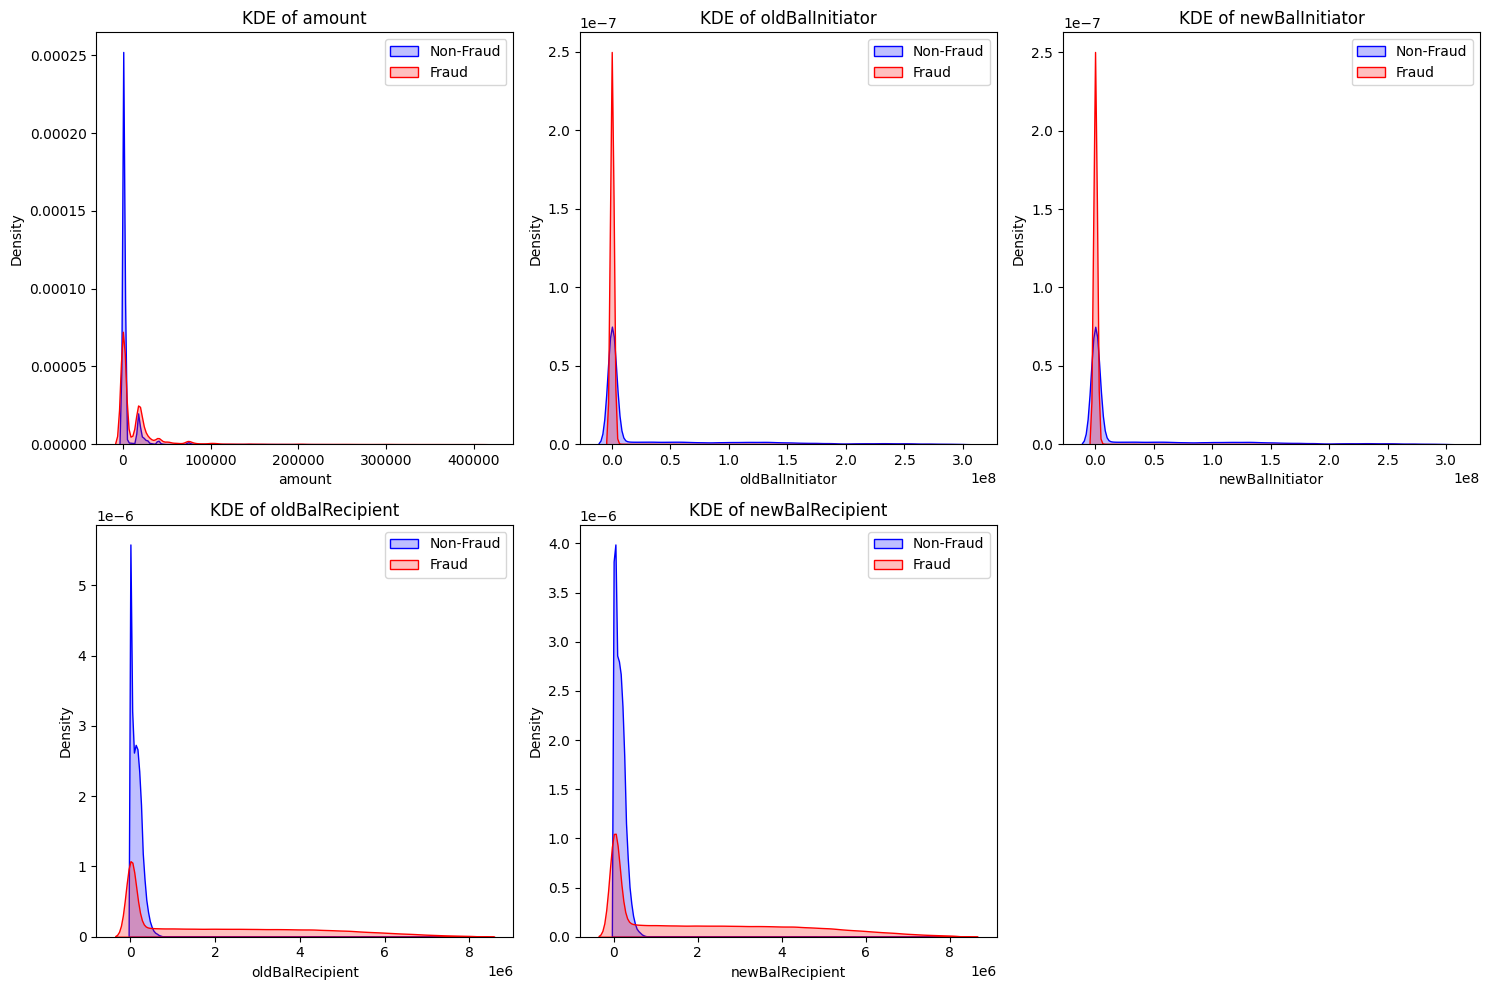

In [32]:
# kde

plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.kdeplot(data=data_cleaned[data_cleaned['isFraud'] == 0][feature], shade=True, label="Non-Fraud", color="blue")
    sns.kdeplot(data=data_cleaned[data_cleaned['isFraud'] == 1][feature], shade=True, label="Fraud", color="red")
    plt.title(f"KDE of {feature}")
    plt.xlabel(feature)
    plt.legend()
plt.tight_layout()
plt.show()


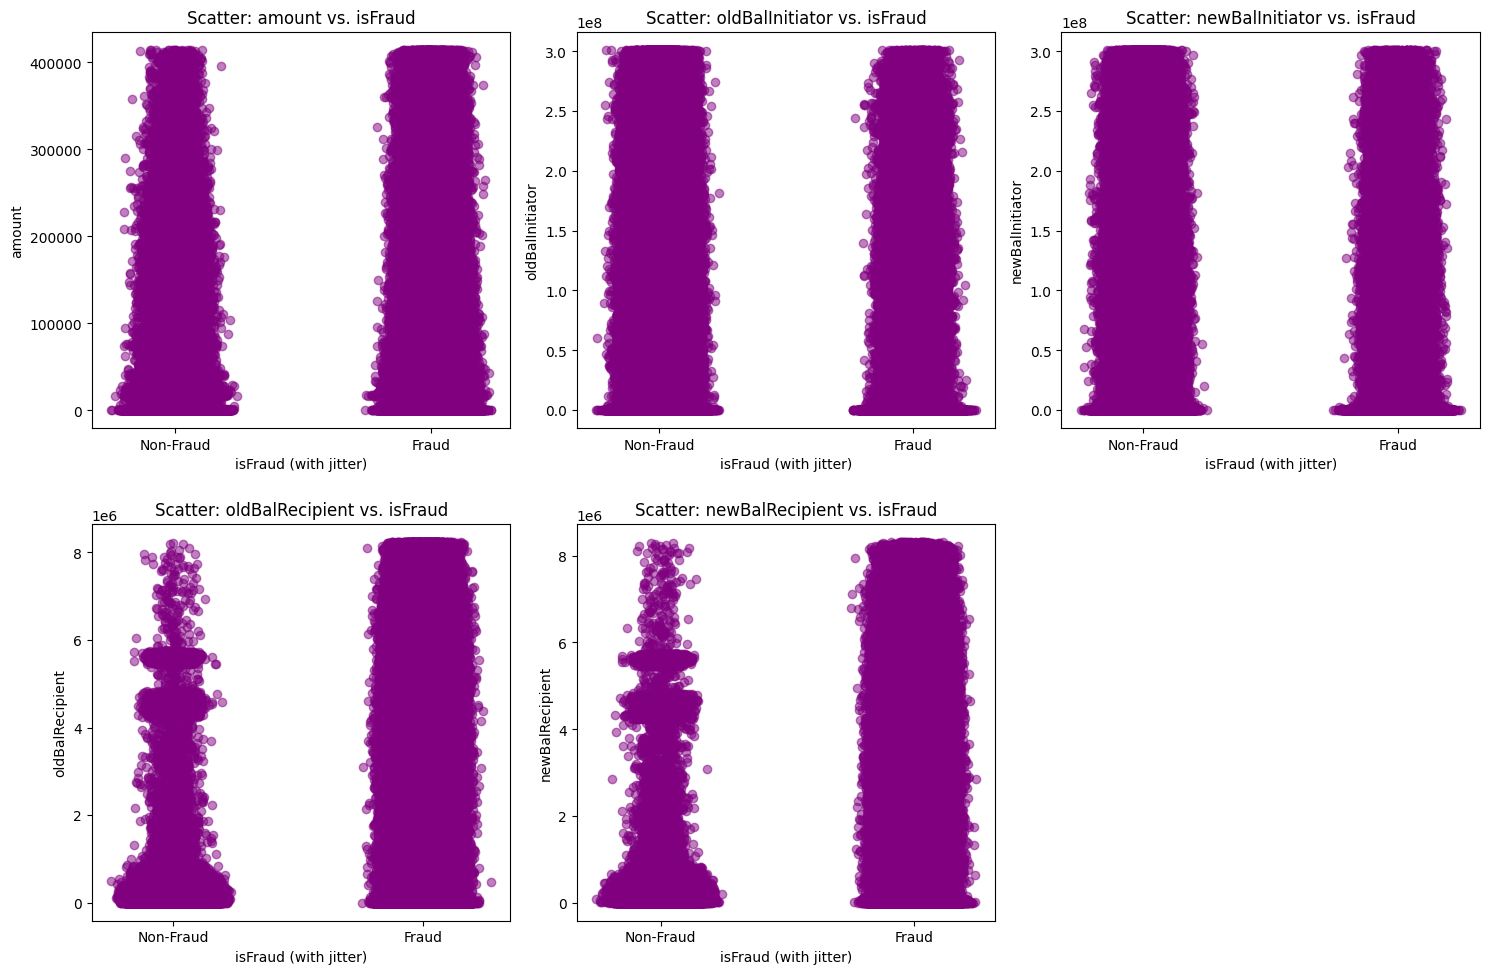

In [33]:
# scatterplot

plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    jitter = np.random.normal(0, 0.05, len(data_cleaned))        # jitter added for better visualization to avoid overlap
    x_jittered = data_cleaned['isFraud'] + jitter
    plt.scatter(x_jittered, data_cleaned[feature], alpha=0.5, color='purple')
    plt.title(f"Scatter: {feature} vs. isFraud")
    plt.xlabel("isFraud (with jitter)")
    plt.ylabel(feature)
    plt.xticks([0, 1], ['Non-Fraud', 'Fraud'])
plt.tight_layout()
plt.show()


<ipython-input-34-7e1a3cd7b15a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-34-7e1a3cd7b15a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-34-7e1a3cd7b15a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-34-7e1a3cd7b15a>:5: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.violinplot(
<ipython-input-34-7e1a3cd7b15a>:5: FutureWarning: 

Pass

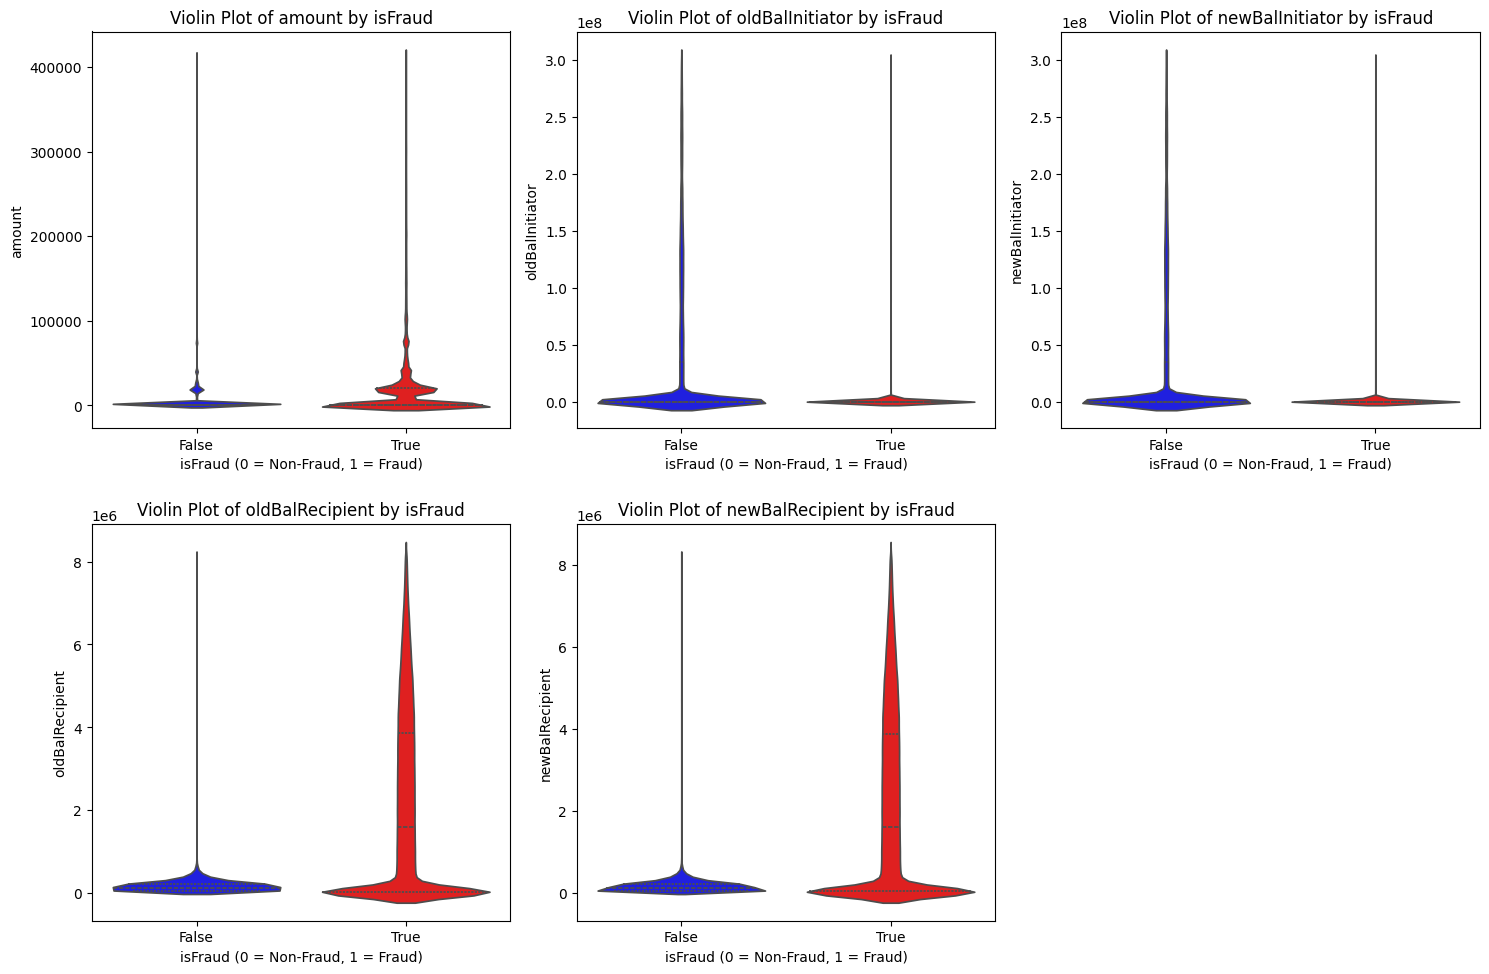

In [34]:
# violin plot
plt.figure(figsize=(15, 10))
for i, feature in enumerate(num_features, 1):
    plt.subplot(2, 3, i)
    sns.violinplot(
        x='isFraud',
        y=feature,
        data=data_cleaned,
        palette=["blue", "red"],
        inner="quartile"          # Shows quartiles inside the violin
    )
    plt.title(f"Violin Plot of {feature} by isFraud")
    plt.xlabel("isFraud (0 = Non-Fraud, 1 = Fraud)")
    plt.ylabel(feature)
plt.tight_layout()
plt.show()


### Correlation

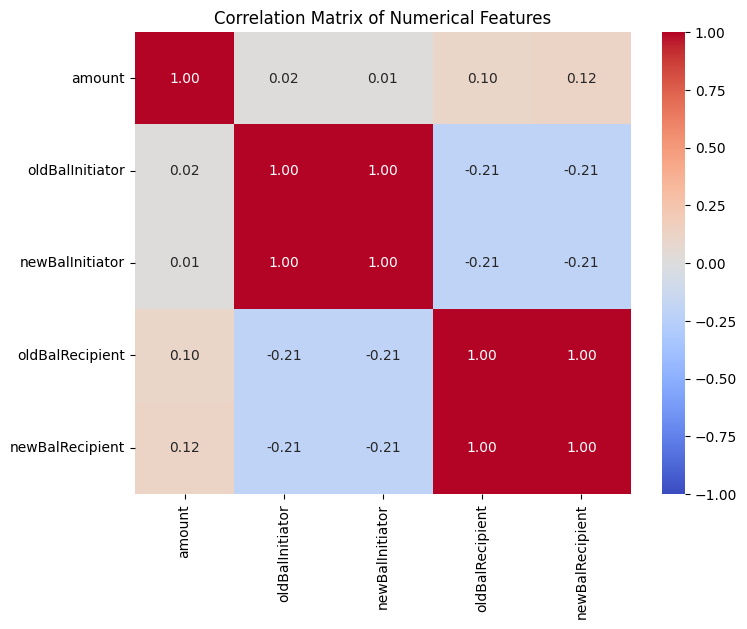

In [35]:
corr_matrix = data_cleaned[num_features].corr()
plt.figure(figsize=(8, 6))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", vmin=-1, vmax=1)
plt.title("Correlation Matrix of Numerical Features")
plt.show()

***Interpretation:***
- Most values lie between -0.21 and 0.12, indicating no strong linear relationships.
-amount has weak positive correlations with oldBalRecipient (0.10) and newBalRecipient (0.12).
-amount shows near-zero correlations (around 0.01 to 0.02) with oldBalInitiator and newBalInitiator.
-oldBalInitiator and newBalInitiator have mild negative correlations (around -0.20 to -0.21) with the recipient’s balances.
-Recipient balances (oldBalRecipient, newBalRecipient) also show weak negative correlations with the initiator’s balances (around -0.21).
-No pair of features exhibits a strong linear relationship

### Statistical Summaries

In [36]:
data_cleaned[num_features].describe()

,amount,oldBalInitiator,newBalInitiator,oldBalRecipient,newBalRecipient
count,4.102723e+06,4.102723e+06,4.102723e+06,4.102723e+06,4.102723e+06
mean,1.590252e+04,1.882089e+07,1.880771e+07,1.220472e+06,1.233143e+06
std,4.349477e+04,5.215644e+07,5.215482e+07,1.892351e+06,1.899243e+06
min,0.000000e+00,-1.999926e+05,-1.999926e+05,0.000000e+00,0.000000e+00
25%,9.261000e+01,4.524000e+01,0.000000e+00,3.220339e+04,4.133173e+04
50%,5.961600e+02,2.730700e+03,0.000000e+00,1.957628e+05,1.984035e+05
75%,1.702368e+04,1.718493e+05,5.656978e+04,1.865257e+06,1.888709e+06
max,4.147995e+05,3.015033e+08,3.014849e+08,8.235418e+06,8.314776e+06


In [37]:
cat_cols = ['transactionType', 'isFraud', 'initiator', 'recipient']

for col in cat_cols:
    print(f"Value counts for {col}:")
    print(data_cleaned[col].value_counts(dropna=False))
    print("\n")

Value counts for transactionType:
transactionType
TRANSFER      2435960
PAYMENT       1632744
WITHDRAWAL      24942
DEPOSIT          7827
DEBIT            1250
Name: count, dtype: int64


Value counts for isFraud:
isFraud
True     2176430
False    1926293
Name: count, dtype: int64


Value counts for initiator:
initiator
4878431234799680    8966
4886362579339875    7653
4390296631400201    7612
4854886205072391    7210
4091331187199402    6794
                    ... 
4733304091984023       1
4652417642177132       1
4456003078591125       1
4187797239488164       1
4581807931497397       1
Name: count, Length: 1603065, dtype: int64


Value counts for recipient:
recipient
00-0009051          1001
23-0001212           987
65-0007287           965
65-0001698           956
32-0002665           952
                    ... 
4839344853771427       1
4803271932204538       1
4960076408743847       1
4165350916056064       1
4789496368283684       1
Name: count, Length: 22076, dtype: int64




## Data Preprocessing and Dataset Splitting

### Some Data Cleaning

In [38]:
# Missing Values - Already Checked Above NONE
# Wrong Datatypes - Already Fixed Above
# Outiers Already Handled Above

In [39]:
# Dropping Duplicates
duplicate_count = data_cleaned.duplicated().sum()
print(duplicate_count)

data_cleaned=data_cleaned.drop_duplicates()

duplicate_count = data_cleaned.duplicated().sum()
print(duplicate_count)

19
0


In [40]:
# check unique vals
for col in cat_cols:
    print(f"Unique values in {col}: {data_cleaned[col].unique()}")

Unique values in transactionType: ['PAYMENT', 'TRANSFER', 'DEBIT', 'WITHDRAWAL', 'DEPOSIT']
Categories (5, object): ['DEBIT', 'DEPOSIT', 'PAYMENT', 'TRANSFER', 'WITHDRAWAL']
Unique values in isFraud: [False  True]
Unique values in initiator: [4018807983755588 4610593854752035 4840578447365454 ... 4934284000016058
 4061535476181592 4553340044344003]
Unique values in recipient: ['30-0000345' '4944921135715488' '4305579785620656' ... '4342586420360577'
 '4865909764204044' '4745484783243825']


In [41]:
# drop features not needed
data_cleaned = data_cleaned.drop(columns=['step'])

### Encoding

In [42]:
# ohe for transactiontype less vals
data_cleaned = pd.get_dummies(data_cleaned, columns=['transactionType'], drop_first=True)

#  target encoding for initiator,recipient high cardinality features
target_enc = ce.TargetEncoder(cols=['initiator', 'recipient'])
data_cleaned[['initiator', 'recipient']] = target_enc.fit_transform(data_cleaned[['initiator', 'recipient']], data_cleaned['isFraud'])

In [43]:
# extra feature drop - used in eda
outlier_columns = [
    'amount_Outlier', 'oldBalInitiator_Outlier', 'newBalInitiator_Outlier',
    'oldBalRecipient_Outlier', 'newBalRecipient_Outlier', 'Combined_Outlier'
]

data_cleaned = data_cleaned.drop(columns=outlier_columns, errors='ignore')


In [44]:
data_cleaned.head()

,amount,initiator,oldBalInitiator,newBalInitiator,recipient,oldBalRecipient,newBalRecipient,isFraud,transactionType_DEPOSIT,transactionType_PAYMENT,transactionType_TRANSFER,transactionType_WITHDRAWAL
0,579.16,0.496094,29.32,29.32,0.000000,0.00,0.00,False,False,True,False,False
1,39.03,0.591574,39.03,0.00,0.999998,55.94,94.98,True,False,False,True,False
2,21.78,0.591574,21.78,0.00,1.000000,58.09,79.88,True,False,False,True,False
3,570.22,0.461466,5.29,5.29,0.000000,0.00,0.00,False,False,True,False,False
4,574.80,0.461466,82.63,82.63,0.000000,0.00,0.00,False,False,True,False,False


### Feature Selection

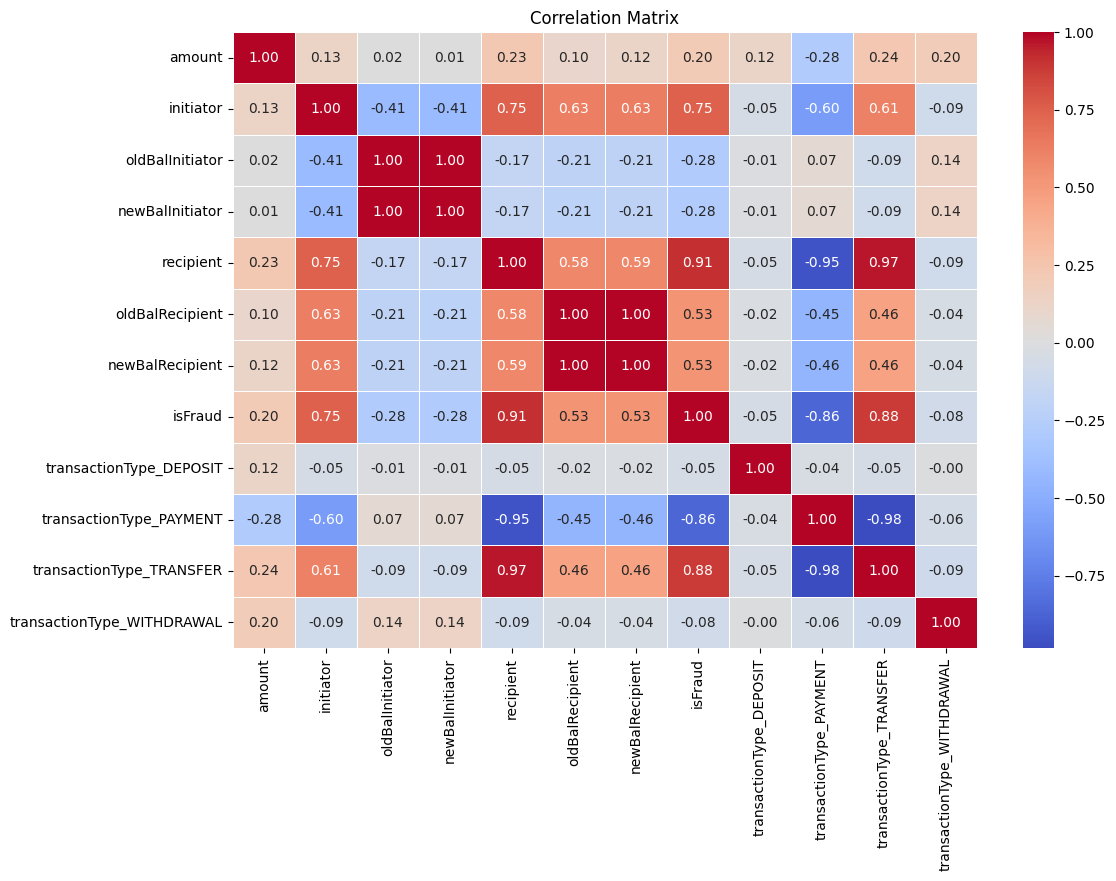

In [45]:
corr_matrix = data_cleaned.corr()

plt.figure(figsize=(12, 8))
sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=0.5)
plt.title("Correlation Matrix")
plt.show()

We are keeping all features because they provide valuable insights into fraudulent transactions.

1. **amount**  
   - Fraudulent transactions often involve unusual amounts.  
   - Shows moderate correlation (0.20) with fraud, making it a useful predictor.  

2. **initiator**  
   - Strong correlation with fraud (0.75), indicating that certain initiators are frequently involved in fraudulent activities.  

3. **recipient**  
   - Extremely high correlation (0.91) with fraud, meaning certain recipients are often associated with fraudulent transactions.  

4. **oldBalInitiator & newBalInitiator**  
   - Fraudulent users may deplete their balance rapidly.  
   - Helps in detecting unusual spending behaviors.  

5. **oldBalRecipient & newBalRecipient**  
   - Shows a notable correlation (0.53) with fraud-related behaviors.  

6. **transactionType_TRANSFER**  
   - Strong correlation (0.88) with fraud cases.  
   - Fraudulent transactions are predominantly transfers rather than withdrawals or deposits.  

7. **transactionType_DEPOSIT, transactionType_PAYMENT, transactionType_WITHDRAWAL**  
   - Even though they have lower correlation, removing them may lead to loss of key fraud patterns.  
   - Useful in distinguishing different types of transactions that could influence fraud detection.  

### Data Splitting

In [46]:
X = data_cleaned.drop(columns=['isFraud'])  # Features
y = data_cleaned['isFraud']  # Target variable

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, stratify=y, random_state=42)

### Normalization

In [47]:
num_cols = ['amount', 'initiator', 'oldBalInitiator', 'newBalInitiator',
            'recipient', 'oldBalRecipient', 'newBalRecipient']

scaler = StandardScaler()
# scaler = MinMaxScaler()

X_train[num_cols] = scaler.fit_transform(X_train[num_cols])
X_test[num_cols] = scaler.transform(X_test[num_cols])

## Model Implementation

In [48]:
# Convert data to GPU DataFrame
X_train_gpu = cudf.DataFrame(X_train)
y_train_gpu = cudf.Series(y_train)
X_test_gpu = cudf.DataFrame(X_test)
y_test_gpu = cudf.Series(y_test)

### K-Nearest Neighbors (KNN) - Euclidean

In [49]:
knn = KNeighborsClassifier(n_neighbors=7, metric='euclidean')

start_train = time.time()
knn.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = knn.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

### Model Evaluation

In [50]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"KNN Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 3.1313 sec
Prediction Time: 74.0793 sec
KNN Accuracy: 0.9679

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    385255
        True       0.98      0.96      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[377518   7737]
 [ 18621 416665]]

Class-wise Accuracy:
Fraud Class (1): 0.9572
Not Fraud Class (0): 0.9799


### K-Nearest Neighbors (KNN) - Manhattan

In [51]:
knn = KNeighborsClassifier(n_neighbors=7, metric='manhattan')

start_train = time.time()
knn.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = knn.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

### Model Evaluation

In [52]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"KNN Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 0.0261 sec
Prediction Time: 189.1000 sec
KNN Accuracy: 0.9683

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    385255
        True       0.98      0.96      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[377783   7472]
 [ 18544 416742]]

Class-wise Accuracy:
Fraud Class (1): 0.9574
Not Fraud Class (0): 0.9806


In [65]:
model_filename = "knn_model.pkl"
save_path = "/content/drive/MyDrive/Fraud_Detection_Models/"

joblib.dump(knn, model_filename)

shutil.move(model_filename, save_path)

['knn_model.pkl']

### SVM - RBF

In [80]:
kernel_type = "rbf"
C_value = 1

svm = SVC(kernel=kernel_type, C=C_value)

start_train = time.time()
svm.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = svm.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

### Model Evaluation

In [81]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"SVM Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 1133.0706 sec
Prediction Time: 73.7692 sec
SVM Accuracy: 0.9702

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    385255
        True       0.99      0.95      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[381600   3655]
 [ 20800 414486]]

Class-wise Accuracy:
Fraud Class (1): 0.9522
Not Fraud Class (0): 0.9905


In [83]:
model_filename = "svm_model.pkl"
save_path = "/content/drive/MyDrive/Fraud_Detection_Models/"

joblib.dump(knn, model_filename)

shutil.move(model_filename, save_path)

'/content/drive/MyDrive/Fraud_Detection_Models/svm_model.pkl'

### SVM - Linear

In [69]:
kernel_type = "linear"
C_value = 1

svm = SVC(kernel=kernel_type, C=C_value)

start_train = time.time()
svm.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = svm.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

[2025-03-29 17:44:55.480] [CUML] [warning] SVC with the linear kernel can be much faster using the specialized solver provided by LinearSVC. Consider switching to LinearSVC if tranining takes too long.


### Model Evaluation

In [70]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"SVM Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 468.6132 sec
Prediction Time: 42.1366 sec
SVM Accuracy: 0.9700

Classification Report:
              precision    recall  f1-score   support

       False       0.94      1.00      0.97    385255
        True       1.00      0.95      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[384386    869]
 [ 23783 411503]]

Class-wise Accuracy:
Fraud Class (1): 0.9454
Not Fraud Class (0): 0.9977


### SVM - Poly

In [77]:
kernel_type = "poly"
C_value = 1

svm = SVC(kernel=kernel_type, C=C_value)

start_train = time.time()
svm.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = svm.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

### Model Evaluation

In [78]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"SVM Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 1828.7103 sec
Prediction Time: 186.8605 sec
SVM Accuracy: 0.9692

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.99      0.97    385255
        True       0.99      0.95      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[381935   3320]
 [ 21967 413319]]

Class-wise Accuracy:
Fraud Class (1): 0.9495
Not Fraud Class (0): 0.9914


### Logistic Regression - L1

In [72]:
log_reg = LogisticRegression(penalty="l1", solver="qn")  # qn is optimzed for gpu in lr

start_train = time.time()
log_reg.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = log_reg.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

[2025-03-29 17:54:21.904] [CUML] [warning] QWL-QN: max iterations reached
[2025-03-29 17:54:21.905] [CUML] [warning] Maximum iterations reached before solver is converged. To increase model accuracy you can increase the number of iterations (max_iter) or improve the scaling of the input data.


### Model Evaluation

In [73]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 23.3858 sec
Prediction Time: 0.0213 sec
Logistic Regression Accuracy: 0.9667

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    385255
        True       0.98      0.95      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[378132   7123]
 [ 20212 415074]]

Class-wise Accuracy:
Fraud Class (1): 0.9536
Not Fraud Class (0): 0.9815


### Logistic Regression - L2

In [84]:
log_reg = LogisticRegression(penalty="l2", solver="qn")  # qn is optimzed for gpu in lr

start_train = time.time()
log_reg.fit(X_train_gpu, y_train_gpu)
end_train = time.time()

start_pred = time.time()
y_pred_gpu = log_reg.predict(X_test_gpu)
end_pred = time.time()

# back to pandas
y_pred = y_pred_gpu.to_pandas()
y_test_cpu = y_test_gpu.to_pandas()

### Model Evaluation

In [85]:
accuracy = accuracy_score(y_test_cpu, y_pred)

print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"Logistic Regression Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")

Training Time: 6.4647 sec
Prediction Time: 0.0127 sec
Logistic Regression Accuracy: 0.9676

Classification Report:
              precision    recall  f1-score   support

       False       0.95      0.98      0.97    385255
        True       0.99      0.95      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[379095   6160]
 [ 20405 414881]]

Class-wise Accuracy:
Fraud Class (1): 0.9531
Not Fraud Class (0): 0.9840


In [86]:
model_filename = "logistic_regression.pkl"
save_path = "/content/drive/MyDrive/Fraud_Detection_Models/"

joblib.dump(knn, model_filename)

shutil.move(model_filename, save_path)

'/content/drive/MyDrive/Fraud_Detection_Models/logistic_regression.pkl'

### Decision Tree

In [87]:
X_train_cpu = pd.DataFrame(X_train)
y_train_cpu = pd.Series(y_train)
X_test_cpu = pd.DataFrame(X_test)
y_test_cpu = pd.Series(y_test)

In [88]:
max_depth = 10
min_samples_split = 10
min_samples_leaf = 5
criterion = "entropy"

dtree = DecisionTreeClassifier(max_depth=max_depth, min_samples_split=min_samples_split, min_samples_leaf=min_samples_leaf,criterion=criterion)

start_train = time.time()
dtree.fit(X_train_cpu, y_train_cpu)
end_train = time.time()

start_pred = time.time()
y_pred = dtree.predict(X_test_cpu)
end_pred = time.time()


### Model Evaluation

In [89]:
print(f"Training Time: {end_train - start_train:.4f} sec")
print(f"Prediction Time: {end_pred - start_pred:.4f} sec")

print(f"Decision Tree Accuracy: {accuracy:.4f}")

print("\nClassification Report:")
print(classification_report(y_test_cpu, y_pred))

print("\nConfusion Matrix:")
conf_matrix = confusion_matrix(y_test_cpu, y_pred)
print(conf_matrix)

class_wise_accuracy = conf_matrix.diagonal() / conf_matrix.sum(axis=1)
print("\nClass-wise Accuracy:")
print(f"Fraud Class (1): {class_wise_accuracy[1]:.4f}")
print(f"Not Fraud Class (0): {class_wise_accuracy[0]:.4f}")


Training Time: 17.2833 sec
Prediction Time: 0.0691 sec
Decision Tree Accuracy: 0.9676

Classification Report:
              precision    recall  f1-score   support

       False       0.95      1.00      0.97    385255
        True       1.00      0.95      0.97    435286

    accuracy                           0.97    820541
   macro avg       0.97      0.97      0.97    820541
weighted avg       0.97      0.97      0.97    820541


Confusion Matrix:
[[384958    297]
 [ 21867 413419]]

Class-wise Accuracy:
Fraud Class (1): 0.9498
Not Fraud Class (0): 0.9992


In [91]:
model_filename = "decision_tree_model.pkl"
save_path = "/content/drive/MyDrive/Fraud_Detection_Models/"

joblib.dump(knn, model_filename)

shutil.move(model_filename, save_path)

'/content/drive/MyDrive/Fraud_Detection_Models/decision_tree_model.pkl'

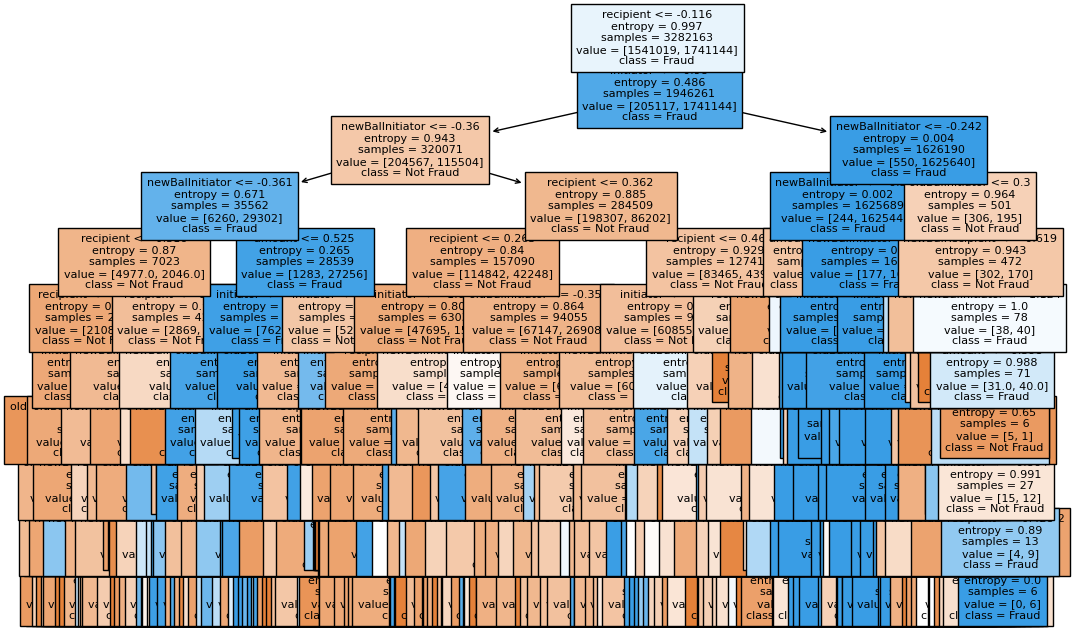

In [90]:
plt.figure(figsize=(12, 8))
plot_tree(dtree, feature_names=X_train_cpu.columns, class_names=["Not Fraud", "Fraud"], filled=True, fontsize=8)
plt.show()